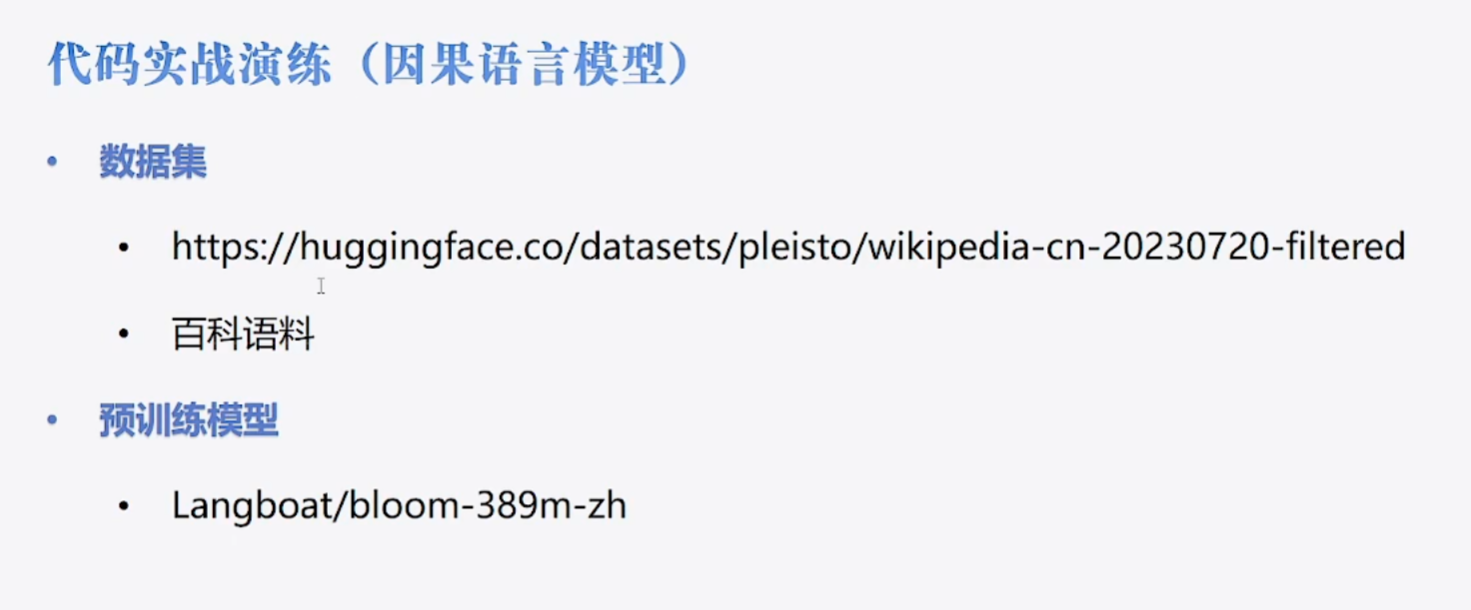

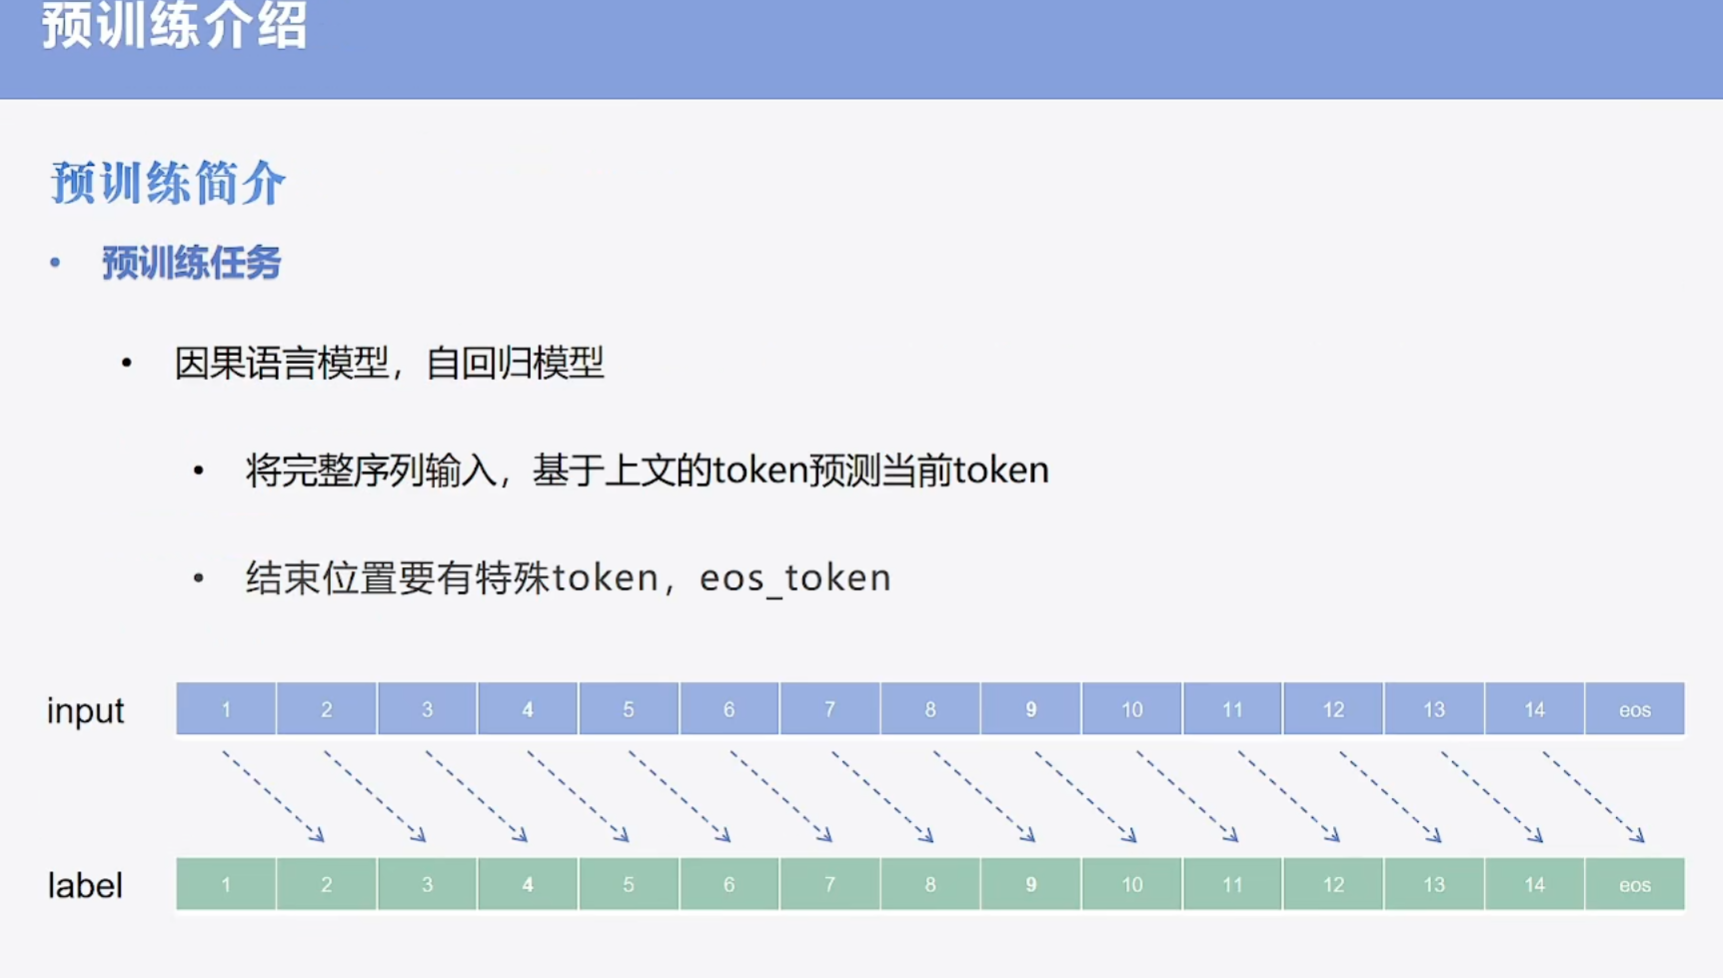

In [1]:
from datasets import load_dataset,Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM,DataCollatorForLanguageModeling,TrainingArguments,Trainer,BloomForCausalLM

In [2]:
ds=Dataset.load_from_disk('./wiki_cn_filtered/')
ds

Dataset({
    features: ['source', 'completion'],
    num_rows: 10000
})

In [3]:
ds[0]

{'source': 'wikipedia.zh2307',
 'completion': "西安交通大学博物馆（Xi'an Jiaotong University Museum）是一座位于西安交通大学的博物馆，馆长是锺明善。\n历史\n2004年9月20日开始筹建，2013年4月8日正式建成开馆，位于西安交通大学兴庆校区陕西省西安市咸宁西路28号。建筑面积6,800平米，展厅面积4,500平米，馆藏文物4,900余件。包括历代艺术文物馆、碑石书法馆、西部农民画馆、邢良坤陶瓷艺术馆、陕西秦腔博物馆和书画展厅共五馆一厅。\n营业时间\n* 周一至周六：上午九点至十二点，下午一点至五点\n* 周日闭馆"}

-------------------------------------

In [4]:
tokenizer = AutoTokenizer.from_pretrained("Langboat/bloom-389m-zh")
print(tokenizer.eos_token )

def process_func(examples):
    contents = [e + tokenizer.eos_token for e in examples["completion"]]
    return tokenizer(contents, max_length=384, truncation=True)

</s>


In [5]:
tokenized_ds=ds.map(process_func,batched=True,remove_columns=ds.column_names)
tokenized_ds

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 10000
})

In [6]:
from torch.utils.data import DataLoader
dl=DataLoader(tokenized_ds,batch_size=2,collate_fn=DataCollatorForLanguageModeling(tokenizer,mlm=False))

In [7]:
next(enumerate(dl))

(0,
 {'input_ids': tensor([[    3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
              3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
              3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
              3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
              3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
              3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
              3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
              3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
              3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
              3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
              3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
              3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
              3,     3

In [8]:
tokenizer.pad_token,tokenizer.pad_token_id     # pad是填充

('<pad>', 3)

In [9]:
tokenizer.eos_token,tokenizer.eos_token_id     # eos是添加的符号，象征着结束

('</s>', 2)

In [10]:
model=AutoModelForCausalLM.from_pretrained("Langboat/bloom-389m-zh")

In [11]:
args = TrainingArguments(
    output_dir="./causalk_lm",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    logging_steps=10,
    num_train_epochs=1
)

In [12]:
trainer=Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds,
    data_collator=DataCollatorForLanguageModeling(tokenizer,mlm=False)
)


In [13]:
trainer.train()

  0%|          | 0/312 [00:00<?, ?it/s]

{'loss': 3.9932, 'grad_norm': 34.65546417236328, 'learning_rate': 4.83974358974359e-05, 'epoch': 0.03}
{'loss': 3.9584, 'grad_norm': 31.271915435791016, 'learning_rate': 4.67948717948718e-05, 'epoch': 0.06}
{'loss': 3.9134, 'grad_norm': 26.784135818481445, 'learning_rate': 4.519230769230769e-05, 'epoch': 0.1}
{'loss': 3.8044, 'grad_norm': 21.59703254699707, 'learning_rate': 4.358974358974359e-05, 'epoch': 0.13}
{'loss': 3.7942, 'grad_norm': 11.443066596984863, 'learning_rate': 4.198717948717949e-05, 'epoch': 0.16}
{'loss': 3.7211, 'grad_norm': 8.195301055908203, 'learning_rate': 4.038461538461539e-05, 'epoch': 0.19}
{'loss': 3.6834, 'grad_norm': 7.445255279541016, 'learning_rate': 3.878205128205129e-05, 'epoch': 0.22}
{'loss': 3.7207, 'grad_norm': 6.3589558601379395, 'learning_rate': 3.717948717948718e-05, 'epoch': 0.26}


KeyboardInterrupt: 

In [ ]:
from transformers import pipeline

pipe = pipeline("text - generation", model=model, tokenizer=tokenizer, device=0)

In [ ]:
pipe("西安交通大学博物馆（Xi'an Jiaotong University Museum）是一座位于西安", max_length=128,do_sample=True)

In [ ]:
pipe("下面是一则游戏新闻。小编报道，近日，游戏产业发展的非常", max_length=128, do_sample=True)